# CPC251 - Project Part1

#### Group Information

Group No: Climate4

- Member 1: Shivabala A/L Ganeish
- Member 2: Pavithran A/L Muthiah
- Member 3: Kishern A/L Prabagaran
- Member 4: Mohamad Azraei bin Johan


#### Import libraries

In [ ]:
%config Completer.use_jedi=False # comment if not needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

#### Load the dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving climate.csv to climate.csv


In [ ]:
df = pd.read_csv('climate.csv')
df.head()

,Study,Run,vconst_corr,vconst_2,vconst_3,vconst_4,vconst_5,vconst_7,ah_corr,ah_bolus,...,efficiency_factor,tidal_mix_max,vertical_decay_scale,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,Prandtl,outcome
0,1,1,0.859036,0.927825,0.252866,0.298838,0.170521,0.735936,0.428325,0.567947,...,0.245675,0.104226,0.869091,0.997518,0.448620,0.307522,0.858310,0.796997,0.869893,0
1,1,2,0.606041,0.457728,0.359448,0.306957,0.843331,0.934851,0.444572,0.828015,...,0.616870,0.975786,0.914344,0.845247,0.864152,0.346713,0.356573,0.438447,0.512256,1
2,1,3,0.997600,0.373238,0.517399,0.504993,0.618903,0.605571,0.746225,0.195928,...,0.679355,0.803413,0.643995,0.718441,0.924775,0.315371,0.250642,0.285636,0.365858,1
3,1,4,0.783408,0.104055,0.197533,0.421837,0.742056,0.490828,0.005525,0.392123,...,0.471463,0.597879,0.761659,0.362751,0.912819,0.977971,0.845921,0.699431,0.475987,1
4,1,5,0.406250,0.513199,0.061812,0.635837,0.844798,0.441502,0.191926,0.487546,...,0.551543,0.743877,0.312349,0.650223,0.522261,0.043545,0.376660,0.280098,0.132283,1


#### Data preprocessing
Perform data preprocessing such as normalization, standardization, label encoding etc.
______________________________________________________________________________________
Description:
We begin by checking for missing values, encoding if necessary, and scaling the numerical features.

In [ ]:
# Check for missing values
df.isnull().sum()

,0
Study,0
Run,0
vconst_corr,0
vconst_2,0
vconst_3,0
vconst_4,0
vconst_5,0
vconst_7,0
ah_corr,0
ah_bolus,0


In [ ]:
# Since all features are numerical, we impute missing values with the mean even though there is none
df.fillna(df.mean(), inplace=True)

In [ ]:
# Drop identifier columns if not useful for prediction
df.drop(columns=['Study', 'Run'], inplace=True)

In [ ]:
# Separate features and target
X = df.drop(columns=['outcome'])
y = df['outcome']

# Scale features only
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reconstruct DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

#### Split the dataset
Split the dataset into training, validation and test sets.

In [ ]:
# Features and target
X = df.drop(columns=['outcome'])
y = df['outcome']

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Second split: 20% validation, 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Check distribution
print("Train set:", X_train.shape, y_train.value_counts(normalize=True).to_dict())
print("Validation set:", X_val.shape, y_val.value_counts(normalize=True).to_dict())
print("Test set:", X_test.shape, y_test.value_counts(normalize=True).to_dict())


Train set: (324, 18) {1: 0.9135802469135802, 0: 0.08641975308641975}
Validation set: (108, 18) {1: 0.9166666666666666, 0: 0.08333333333333333}
Test set: (108, 18) {1: 0.9166666666666666, 0: 0.08333333333333333}


#### Feature Selection
Perform feature selection to select the relevant features.
______________________________________________________________________________________
Description: We use correlation heatmap and feature importance via ExtraTreesRegressor to identify the top predictors for the target.

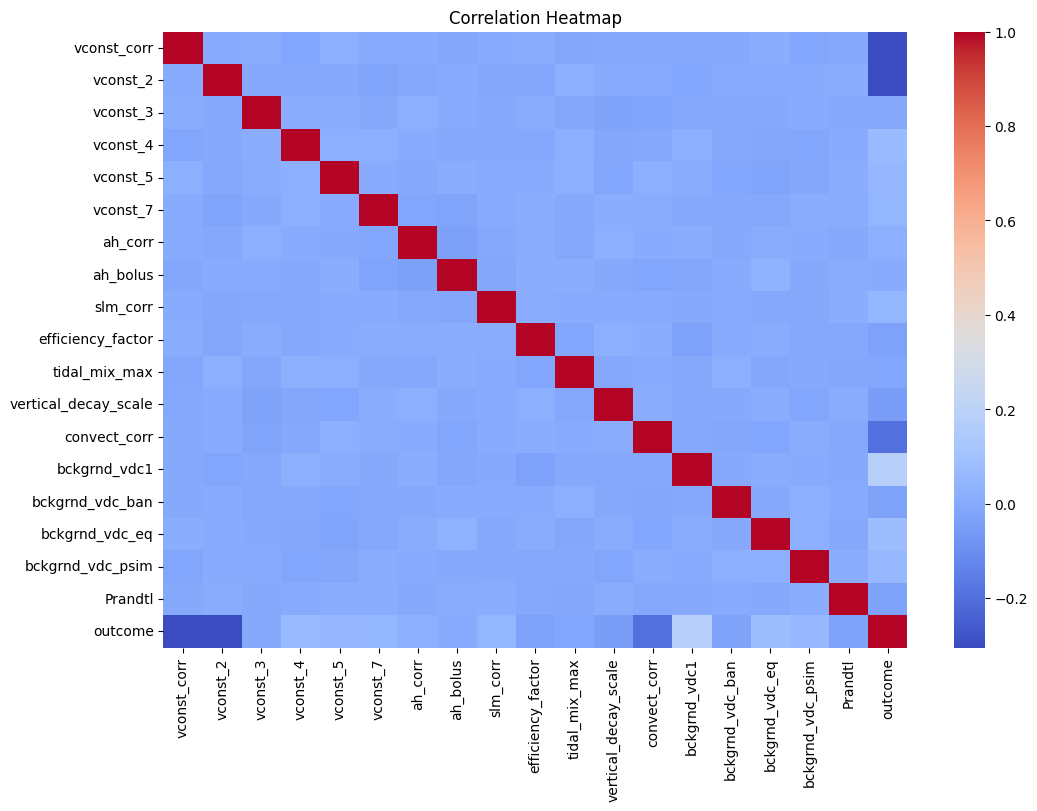

In [ ]:
# Correlation heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

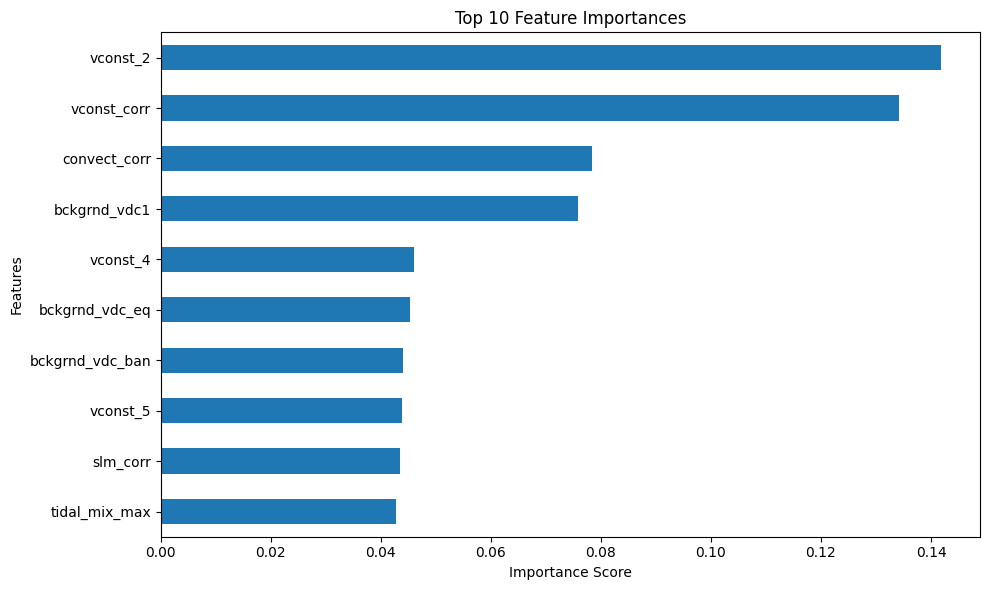

In [ ]:
# Separate features and target
X = df.drop(columns=['outcome'])
y = df['outcome']

# Convert float-like binary values (e.g., 0.0 and 1.0) to integer class labels
df['outcome'] = df['outcome'].astype(int)
model = ExtraTreesClassifier()
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)

# Top 10 features
top_features = importances.sort_values(ascending=False).head(10)


# Plot
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Highest importance on top
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

#### Justification of Selected Features

We selected the top 10 features based on `ExtraTreesClassifier` importance scores. These features are most influential in predicting the `outcome` variable. Correlation analysis also helped avoid redundant features due to multicollinearity.

#### Data modeling
Build the machine learning models. You must build atleast two (2) predictive models. One of the predictive models must be either Decision Tree or Support Vector Machine.
______________________________________________________________________________________
Description:<br> We have implemented and evaluated two classification predictive models which are Decision Tree Classification and K-Nearest Neighbors on the climate.csv dataset. <br>
For each model, we first train the predictive models without any tuning and evaluate the classification metrics then, we tuned each model via 'GridSearchCV' class and evaluate the metrics again to find whether there is any improvements in the performance of the predictive models. We also visualized both tuned and untuned confusion metrics via 'ConfusionMatrixDisplay' class for each predictive models for better and clear understanding of the performance difference before and after fine tuning the models.

####1st Model: Decision Tree Classification

****** Decision Tree Before Tuning ******

Accuracy: 0.8703703703703703
Precision: 0.9381443298969072
Recall: 0.9191919191919192
F1 Score: 0.9285714285714286

Confusion Matrix:
 [[ 3  6]
 [ 8 91]]

Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.33      0.30         9
           1       0.94      0.92      0.93        99

    accuracy                           0.87       108
   macro avg       0.61      0.63      0.61       108
weighted avg       0.88      0.87      0.88       108



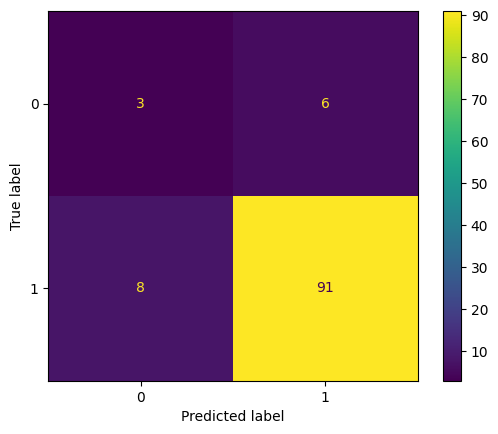

In [ ]:
# fit Decision Tree without any tuning
clf = DecisionTreeClassifier().fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Decision Tree Metrics Before Tuning
print("****** Decision Tree Before Tuning ******")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=y.unique())
cm_display.plot(values_format='d')
plt.show()

****** Decision Tree After Tuning ******

Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}

Accuracy: 0.9074074074074074
Precision: 0.9320388349514563
Recall: 0.9696969696969697
F1 Score: 0.9504950495049505

Confusion Matrix:
 [[ 2  7]
 [ 3 96]]

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.22      0.29         9
           1       0.93      0.97      0.95        99

    accuracy                           0.91       108
   macro avg       0.67      0.60      0.62       108
weighted avg       0.89      0.91      0.90       108



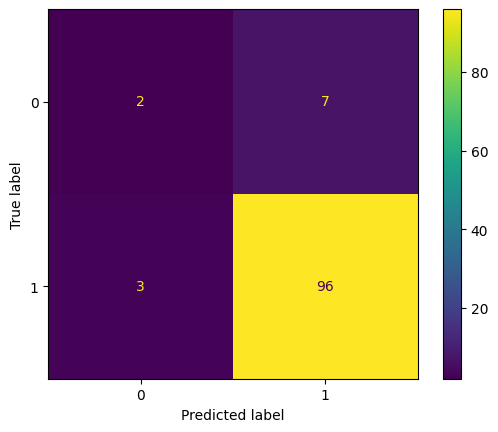

In [ ]:
# Decision Tree After Tuning

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

# Decision Tree Metrics After Tuning
print("****** Decision Tree After Tuning ******")
print("\nBest Parameters:", grid_search.best_params_)
print("\nAccuracy:", accuracy_score(y_test, y_pred_tuned))
print("Precision:", precision_score(y_test, y_pred_tuned))
print("Recall:", recall_score(y_test, y_pred_tuned))
print("F1 Score:", f1_score(y_test, y_pred_tuned))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
cm_display = ConfusionMatrixDisplay(cm, display_labels=y.unique())
cm_display.plot(values_format='d')
plt.show()

####2nd Model: K-Nearest Neighbours Classification

****** K-Nearest Neighbors Before Tuning ******

Accuracy: 0.9166666666666666
Precision: 0.9166666666666666
Recall: 1.0
F1 Score: 0.9565217391304348

Confusion Matrix:
 [[ 0  9]
 [ 0 99]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.92      1.00      0.96        99

    accuracy                           0.92       108
   macro avg       0.46      0.50      0.48       108
weighted avg       0.84      0.92      0.88       108



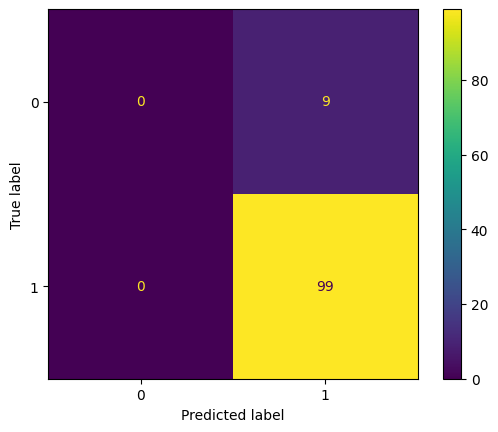

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize and train KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Make predictions
y_pred = knn_model.predict(X_test)

# Evaluate model
print("****** K-Nearest Neighbors Before Tuning ******")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='binary', zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='binary', zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, average='binary', zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=y.unique())
cm_display.plot(values_format='d')
plt.show()


****** K-Nearest Neighbors After Tuning ******

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Accuracy: 0.8981481481481481
Precision: 0.9150943396226415
Recall: 0.9797979797979798
F1 Score: 0.9463414634146341

Confusion Matrix:
 [[ 0  9]
 [ 2 97]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.92      0.98      0.95        99

    accuracy                           0.90       108
   macro avg       0.46      0.49      0.47       108
weighted avg       0.84      0.90      0.87       108



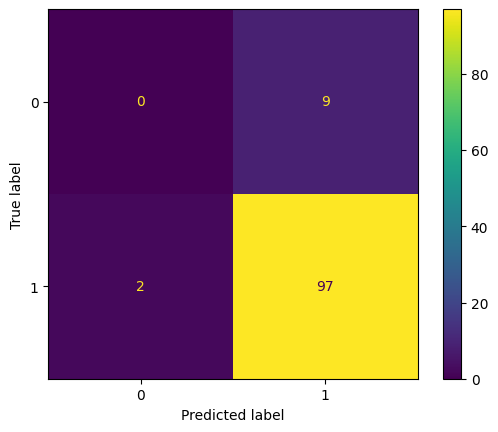

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Set up grid search
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

# Evaluate tuned model
print("****** K-Nearest Neighbors After Tuning ******")
print("\nBest Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Precision:", precision_score(y_test, y_pred_tuned, average='binary'))
print("Recall:", recall_score(y_test, y_pred_tuned, average='binary'))
print("F1 Score:", f1_score(y_test, y_pred_tuned, average='binary'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred_tuned)
cm_display = ConfusionMatrixDisplay(cm, display_labels=y.unique())
cm_display.plot(values_format='d')
plt.show()


#### Evaluate the models
Perform a comparison between the predictive models. <br>
Report the accuracy, recall, precision and F1-score measures as well as the confusion matrix if it is a classification problem. <br>
 Report the R² score, mean squared error and mean absolute error if it is a regression problem.
______________________________________________________________________________________
Description:

## Comparison Between Predictive Models

To identify the most effective predictive model for our problem, we trained and evaluated two models. The performance of each model was assessed using standard evaluation metrics.

- For **Decision Tree classification**: Accuracy, Precision, Recall, F1-score, and Confusion Matrix.
- For **K-Nearest Neighbours classification**: Accuracy, Precision, Recall, F1-score, and Confusion Matrix.

We compare these metrics side-by-side to determine which model offers the best trade-off between performance and complexity.

####Decision Tree Classification
--------------------------------

In [ ]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

# Decision Tree Metrics After Tuning
print("****** Decision Tree After Tuning ******")
print("\nAccuracy:", accuracy_score(y_test, y_pred_tuned))
print("Precision:", precision_score(y_test, y_pred_tuned))
print("Recall:", recall_score(y_test, y_pred_tuned))
print("F1 Score:", f1_score(y_test, y_pred_tuned))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))

****** Decision Tree After Tuning ******

Accuracy: 0.9074074074074074
Precision: 0.9320388349514563
Recall: 0.9696969696969697
F1 Score: 0.9504950495049505

Confusion Matrix:
 [[ 2  7]
 [ 3 96]]

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.22      0.29         9
           1       0.93      0.97      0.95        99

    accuracy                           0.91       108
   macro avg       0.67      0.60      0.62       108
weighted avg       0.89      0.91      0.90       108



####K-Nearest Neighbor Classification
------------------------------------

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Set up grid search
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

# Evaluate tuned model
print("****** K-Nearest Neighbors After Tuning ******")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Precision:", precision_score(y_test, y_pred_tuned, average='binary'))
print("Recall:", recall_score(y_test, y_pred_tuned, average='binary'))
print("F1 Score:", f1_score(y_test, y_pred_tuned, average='binary'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))

****** K-Nearest Neighbors After Tuning ******
Accuracy: 0.8981481481481481
Precision: 0.9150943396226415
Recall: 0.9797979797979798
F1 Score: 0.9463414634146341

Confusion Matrix:
 [[ 0  9]
 [ 2 97]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.92      0.98      0.95        99

    accuracy                           0.90       108
   macro avg       0.46      0.49      0.47       108
weighted avg       0.84      0.90      0.87       108



####Model Analysis
------------------------------------

In [ ]:
# Comparison table
comparison_data = {
    "Metric": [
        "Accuracy (Classification)",
        "Precision (Classification)",
        "Recall (Classification)",
        "F1-Score (Classification)"
    ],
    "Decision Tree": [
        0.9074,
        0.9321,
        0.9697,
        0.9505
    ],
    "K-Nearest Neighbor": [
        0.8981,
        0.9151,
        0.9798,
        0.9463
    ]
}

# Convert to DataFrame and display
comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison Table\n")
print(comparison_df.to_string(index=False))

Model Comparison Table

                    Metric  Decision Tree  K-Nearest Neighbor
 Accuracy (Classification)         0.9074              0.8981
Precision (Classification)         0.9321              0.9151
   Recall (Classification)         0.9697              0.9798
 F1-Score (Classification)         0.9505              0.9463


##Decision Tree

- Accuracy: 90.74% - Slightly better overall predictive performance

- Precision: 93.20% - Better at minimizing false positives

- Recall: 96.97% - Slightly lower recall than KNN but still excellent

- F1-Score: 95.05% - Shows the best balance between precision and recall

Advantages:

- Best overall performance across all metrics

- More precise predictions than KNN

- Typically faster at prediction time

Considerations:

- Marginally lower recall than KNN

- May be more prone to overfitting without proper tuning

##K-Nearest Neighbors (KNN)
- Accuracy: 89.81% - Good performance, slightly below Decision Tree

- Precision: 91.51% - More false positives than Decision Tree

- Recall: 97.98% - Best among the two models at identifying positives

- F1-Score: 94.63% - Strong, but slightly below Decision Tree

Advantages:

- Highest recall (best at finding all positive cases)

- Simple implementation

- No training phase required

Considerations:

- Computationally intensive with large datasets

- Requires careful feature scaling

- Slightly lower precision than Decision Tree

###Conclusion

For most applications, the Decision Tree would be the preferred choice as it offers:

- Better overall accuracy

- Higher precision (fewer false positives)

- Superior balanced performance (F1-Score)

Consider KNN if:

- Maximizing recall is top priority (identifying all positive cases is crucial)

- Working with a small to medium-sized dataset

- Can tolerate slightly more false positives